# LiDAR Data Visualization

This notebook demonstrates how to visualize LAS files effectively with proper memory management.

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import laspy
import os
from mpl_toolkits.mplot3d import Axes3D

# Set style for better visuals
plt.style.use('bmh')

## LiDAR Data

Load the LAS file into a pandas DataFrame with proper handling

In [36]:
def load_las_to_dataframe(filename, max_points=1000000):
    """
    Load LAS file data into a pandas DataFrame with improved memory management.
    
    Parameters:
    -----------
    filename : str
        Path to the LAS file
    max_points : int or None
        Maximum number of points to load (default: 1 million)
        Set to None to attempt loading all points (warning: may cause memory errors)
    
    Returns:
    --------
    pd.DataFrame
        DataFrame containing LiDAR point data
    """
    print(f"Loading LAS file: {filename}...")
    
    # Check if file exists
    if not os.path.exists(filename):
        raise FileNotFoundError(f"File {filename} not found.")
    
    # First just get the header to check total points
    with laspy.open(filename) as fh:
        total_points = fh.header.point_count
        print(f"Total points in file: {total_points:,}")
        
        # Check available dimensions
        point_format = fh.header.point_format
        print(f"Available dimensions: {list(point_format.dimension_names)}")
    
    # Determine how many points to process
    if max_points is None:
        print("Warning: Attempting to load all points. This may cause memory issues.")
        points_to_load = total_points
    else:
        points_to_load = min(max_points, total_points)
        print(f"Loading {points_to_load:,} points ({(points_to_load/total_points)*100:.1f}% of data)")
    
    # Use random sampling for large files
    if points_to_load < total_points:
        # Calculate sampling ratio
        sampling_ratio = points_to_load / total_points
        
        try:
            # Use chunked reading with appropriate dtypes
            chunk_size = min(100000, total_points)  # Smaller chunks to reduce memory usage
            df_chunks = []
            points_loaded = 0
            
            with laspy.open(filename) as fh:
                for chunk in fh.chunk_iterator(chunk_size):
                    # Apply random sampling to this chunk
                    if sampling_ratio < 1.0:
                        mask = np.random.random(len(chunk)) < sampling_ratio
                        if np.sum(mask) == 0 and len(chunk) > 0:  # Ensure at least one point from chunk
                            mask[0] = True
                        chunk_points = chunk.points[mask]
                    else:
                        chunk_points = chunk.points
                    
                    # Extract point data directly into a DataFrame with appropriate dtypes
                    chunk_df = pd.DataFrame({
                        'X': chunk_points.x.astype(np.float32),
                        'Y': chunk_points.y.astype(np.float32),
                        'Z': chunk_points.z.astype(np.float32),
                        'intensity': chunk_points.intensity.astype(np.uint16),
                        'classification': chunk_points.classification.astype(np.uint8),
                        'return_number': chunk_points.return_number.astype(np.uint8),
                        'number_of_returns': chunk_points.number_of_returns.astype(np.uint8)
                    })
                    
                    df_chunks.append(chunk_df)
                    points_loaded += len(chunk_df)
                    print(f"Loaded {points_loaded:,} points so far...")
                    
                    # Stop if we've reached our target
                    if points_loaded >= points_to_load:
                        break
            
            # Concatenate all chunks
            df = pd.concat(df_chunks, ignore_index=True)
            
        except MemoryError:
            print("Memory error encountered. Trying with stricter sampling...")
            # If we hit a memory error, try again with even fewer points
            return load_las_to_dataframe(filename, max_points=max_points//2)
    else:
        # For smaller files, use chunked approach to avoid memory issues
        try:
            chunk_size = min(100000, total_points)  # Smaller chunks
            df_chunks = []
            points_loaded = 0
            
            with laspy.open(filename) as fh:
                for chunk in fh.chunk_iterator(chunk_size):
                    # Extract point data directly into a DataFrame with appropriate dtypes
                    chunk_df = pd.DataFrame({
                        'X': chunk.x.astype(np.float32),
                        'Y': chunk.y.astype(np.float32),
                        'Z': chunk.z.astype(np.float32),
                        'intensity': chunk.intensity.astype(np.uint16),
                        'classification': chunk.classification.astype(np.uint8),
                        'return_number': chunk.return_number.astype(np.uint8),
                        'number_of_returns': chunk.number_of_returns.astype(np.uint8)
                    })
                    
                    df_chunks.append(chunk_df)
                    points_loaded += len(chunk_df)
                    print(f"Loaded {points_loaded:,} points so far...")
                    
                    # Stop if we've reached our target
                    if points_loaded >= points_to_load:
                        break
                        
            # Concatenate all chunks
            df = pd.concat(df_chunks, ignore_index=True)
            
            # Optionally add other fields
            for field in ['scan_angle_rank', 'user_data', 'point_source_id', 'gps_time']:
                try:
                    # Check if field exists in the chunk data first
                    with laspy.open(filename) as fh:
                        sample = next(fh.chunk_iterator(1))
                        if hasattr(sample, field):
                            # We'd need to reload the data to get these fields, so just note it
                            print(f"Note: Field '{field}' is available but not loaded")
                except (AttributeError, KeyError) as e:
                    print(f"Field '{field}' not available: {e}")
                    
        except MemoryError:
            print("Memory error encountered. Trying with sampling...")
            # If direct read fails, fall back to chunked reading with sampling
            return load_las_to_dataframe(filename, max_points=1000000)
    
    print(f"DataFrame created with {len(df):,} points")
    return df

In [37]:
# Load a sample of the data that fits in memory
filename = "../data/2743_1234.las"

try:
    # Start with a smaller number of points first to test the file
    df = load_las_to_dataframe(filename, max_points=100000)  
    
    # If successful, display the first few rows
    df.head()
except AttributeError as e:
    # Check the LAS file structure
    with laspy.open(filename) as fh:
        print(f"Available dimensions: {list(fh.header.point_format.dimension_names)}")
        # Load using direct read method instead
        las = laspy.read(filename)
        
        # Create DataFrame directly with available dimensions
        df = pd.DataFrame({
            'X': np.array(las.x).astype(float),
            'Y': np.array(las.y).astype(float),
            'Z': np.array(las.z).astype(float),
            'intensity': np.array(las.intensity),
            'return_number': np.array(las.return_number),
            'number_of_returns': np.array(las.number_of_returns),
            'scan_direction_flag': np.array(las.scan_direction_flag),
            'edge_of_flight_line': np.array(las.edge_of_flight_line),
            'classification': np.array(las.classification),
            'synthetic': np.array(las.synthetic),
            'key_point': np.array(las.key_point),
            'withheld': np.array(las.withheld),
            'scan_angle_rank': np.array(las.scan_angle_rank),
            'user_data': np.array(las.user_data),
            'point_source_id': np.array(las.point_source_id),
            'gps_time': np.array(las.gps_time)
        })

        print(f"Loaded {len(df):,} points using direct read method")
        df.head()

Loading LAS file: ../data/2743_1234.las...
Total points in file: 20,985,999
Available dimensions: ['X', 'Y', 'Z', 'intensity', 'return_number', 'number_of_returns', 'scan_direction_flag', 'edge_of_flight_line', 'classification', 'synthetic', 'key_point', 'withheld', 'scan_angle_rank', 'user_data', 'point_source_id', 'gps_time']
Loading 100,000 points (0.5% of data)
Available dimensions: ['X', 'Y', 'Z', 'intensity', 'return_number', 'number_of_returns', 'scan_direction_flag', 'edge_of_flight_line', 'classification', 'synthetic', 'key_point', 'withheld', 'scan_angle_rank', 'user_data', 'point_source_id', 'gps_time']
Loaded 20,985,999 points using direct read method


In [44]:
def prepare_data_for_visualization(df, max_points=100000):
    """
    Flatten nested arrays in DataFrame for visualization
    """
    # Create empty lists for flattened data
    x_values, y_values, z_values = [], [], []
    intensity_values = []
    
    # Sample rows if there are too many
    sample_rows = min(len(df), max_points // 100)  # Estimate ~100 points per row
    df_sample = df.sample(sample_rows) if sample_rows < len(df) else df
    
    print(f"Processing {len(df_sample)} rows of nested data...")
    
    # Extract individual points from nested arrays
    for _, row in df_sample.iterrows():
        # Make sure we're dealing with arrays
        x_array = np.array(row['X']) if isinstance(row['X'], (list, np.ndarray)) else np.array([row['X']])
        y_array = np.array(row['Y']) if isinstance(row['Y'], (list, np.ndarray)) else np.array([row['Y']])
        z_array = np.array(row['Z']) if isinstance(row['Z'], (list, np.ndarray)) else np.array([row['Z']])
        
        # Take a random subset of points from this row if there are many
        if len(x_array) > 100:
            indices = np.random.choice(len(x_array), 100, replace=False)
            x_array = x_array[indices]
            y_array = y_array[indices]
            z_array = z_array[indices]
        
        # Append values to our lists
        x_values.extend(x_array)
        y_values.extend(y_array)
        z_values.extend(z_array)
        
        # Handle intensity (might be a single value per row)
        if isinstance(row['intensity'], (list, np.ndarray)):
            # If intensity is an array, match it with the coordinate arrays
            if len(x_array) <= len(row['intensity']):
                intensity_values.extend(row['intensity'][:len(x_array)])
            else:
                # Repeat the intensity value or array
                intensity_values.extend([row['intensity'][0]] * len(x_array))
        else:
            # Single intensity value for the whole row
            intensity_values.extend([row['intensity']] * len(x_array))
    
    # Create a new DataFrame with flattened data
    flat_df = pd.DataFrame({
        'X': x_values,
        'Y': y_values,
        'Z': z_values,
        'intensity': intensity_values
    })
    
    print(f"Created flat DataFrame with {len(flat_df)} points")
    return flat_df

In [45]:
def visualize_lidar_3d(df, max_points=100000):
    """
    Create a 3D visualization of LiDAR data, handling nested arrays
    """
    # First, check if we need to flatten the data
    is_nested = False
    if len(df) > 0:
        if isinstance(df['X'].iloc[0], (list, np.ndarray)):
            is_nested = True
    
    # Flatten nested data if needed
    if is_nested:
        print("Detected nested arrays in data. Flattening for visualization...")
        visualization_df = prepare_data_for_visualization(df, max_points)
    else:
        print("Data is already flat. Sampling for visualization...")
        # For flat data, just sample if needed
        if len(df) > max_points:
            visualization_df = df.sample(max_points)
        else:
            visualization_df = df
    
    # Reset matplotlib state
    plt.close('all')
    
    # Create the 3D plot
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Create scatter plot
    scatter = ax.scatter(
        visualization_df['X'], 
        visualization_df['Y'], 
        visualization_df['Z'],
        c=visualization_df['intensity'],
        cmap='viridis',
        s=2,
        alpha=0.6
    )
    
    # Add labels and title
    ax.set_title('3D LiDAR Point Cloud Visualization')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    
    # Add a colorbar
    fig.colorbar(scatter, ax=ax, label='Intensity')
    
    plt.tight_layout()
    return fig

Processing 2000 rows of nested data...
Created flat DataFrame with 2000 points
Data is already flat. Sampling for visualization...


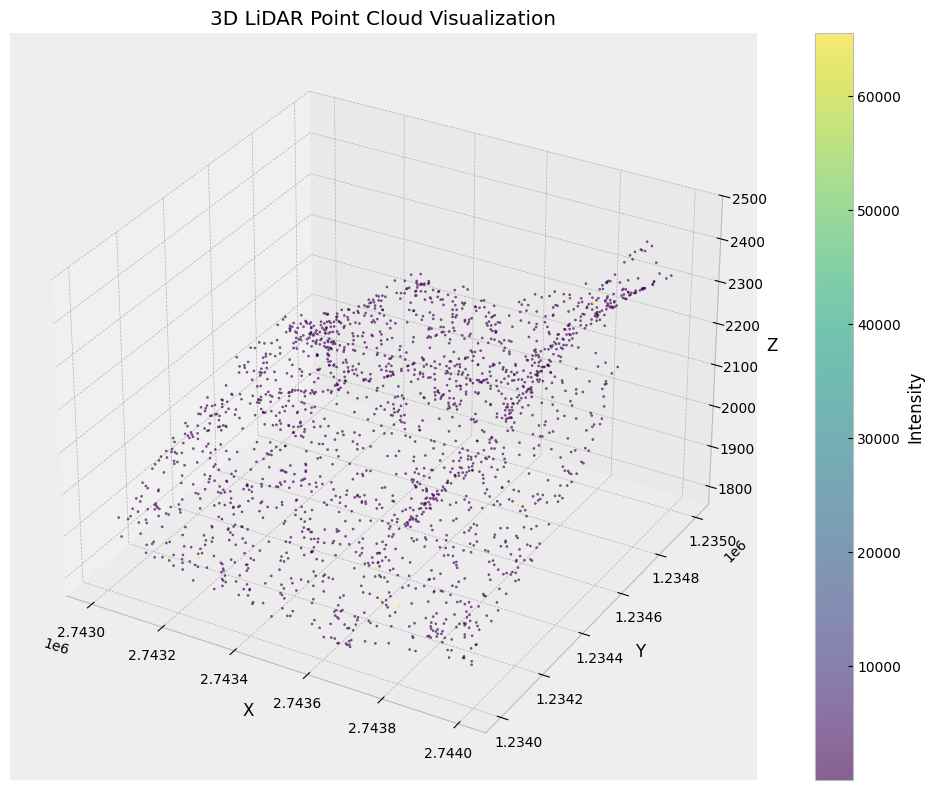

In [46]:
# Load the data again with a larger sample size
flat_df = prepare_data_for_visualization(df, max_points=200000)

# Then create visualization
fig = visualize_lidar_3d(flat_df)
plt.show()


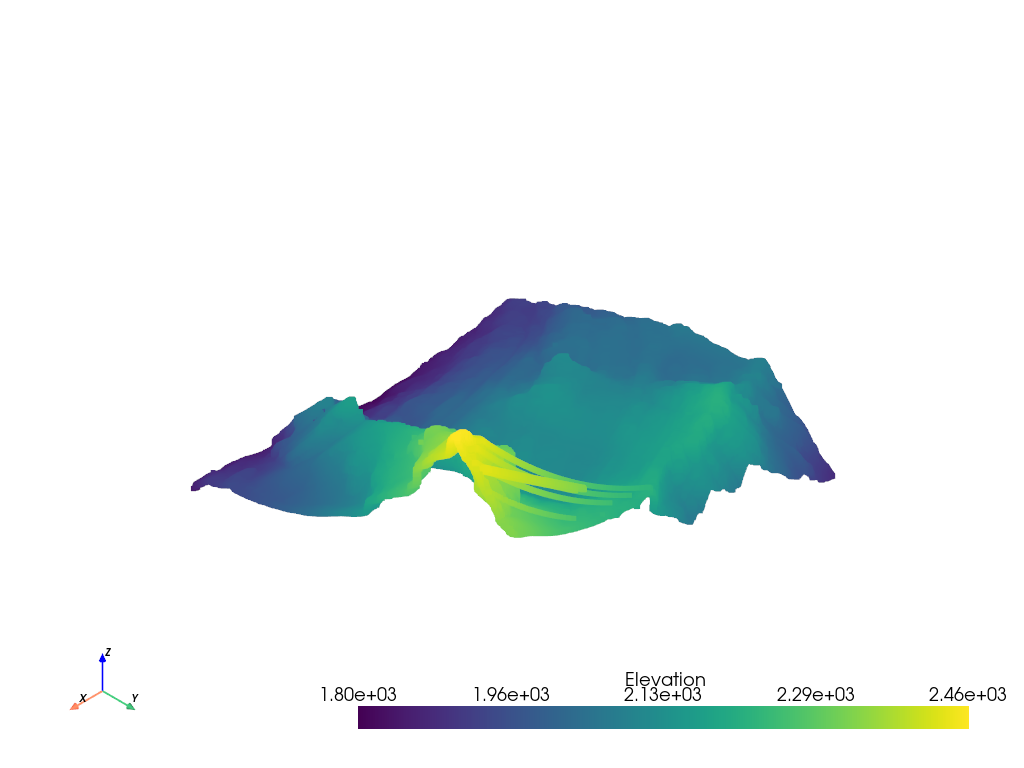

In [50]:
import geemap
geemap.view_lidar(filename, backend='ipygany', background='white')

## Basic Statistics

In [31]:
# Display basic statistics
df.describe(include='all')

,X,Y,Z,intensity,return_number,number_of_returns,scan_direction_flag,edge_of_flight_line,classification,synthetic,key_point,withheld,scan_angle_rank,user_data,point_source_id,gps_time
count,20985999,20985999,20985999,2.098600e+07,20985999,20985999,20985999,20985999,20985999,20985999,20985999,20985999,2.098600e+07,2.098600e+07,2.098600e+07,2.098600e+07
unique,1,1,1,NaN,1,1,1,1,1,1,1,1,NaN,NaN,NaN,NaN
top,"[2743000.0, 2743000.0, 2743000.0, 2743000.0, 2...","[1234840.87, 1234836.69, 1234836.45, 1234833.5...","[2022.98, 2027.5800000000002, 2027.65, 2030.06...",NaN,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN,NaN,NaN,NaN
freq,20985999,20985999,20985999,NaN,20985999,20985999,20985999,20985999,20985999,20985999,20985999,20985999,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,7.441024e+02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-4.052820e-01,5.470626e+01,1.452964e+03,1.925256e+08
std,NaN,NaN,NaN,4.578274e+03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.722888e+01,6.194551e+00,9.391578e+01,1.737942e+06
min,NaN,NaN,NaN,1.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3.000000e+01,0.000000e+00,1.441000e+03,1.923503e+08
25%,NaN,NaN,NaN,3.110000e+02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.600000e+01,5.300000e+01,1.443000e+03,1.923514e+08
50%,NaN,NaN,NaN,3.980000e+02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00,5.400000e+01,1.444000e+03,1.923514e+08
75%,NaN,NaN,NaN,5.020000e+02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.400000e+01,5.600000e+01,1.444000e+03,1.923519e+08


In [ ]:
from sklearn.preprocessing import RobustScaler

def apply_robust_scaler(df, columns):
    """
    Apply RobustScaler to specified columns of a DataFrame.
    
    Parameters:
    -----------
    df : pd.DataFrame
        The input DataFrame.
    columns : list of str
        List of column names to scale.
    
    Returns:
    --------
    pd.DataFrame
        DataFrame with scaled columns.
    """
    scaler = RobustScaler()
    df_scaled = df.copy()
    df_scaled[columns] = scaler.fit_transform(df[columns])
    return df_scaled


scaled_df = apply_robust_scaler(df, ['X', 'Y', 'Z', 'intensity'])
scaled_df.head()

,X,Y,Z,intensity,return_number,number_of_returns,scan_direction_flag,edge_of_flight_line,classification,synthetic,key_point,withheld,scan_angle_rank,user_data,point_source_id,gps_time
0,-1.05281,0.671937,-0.164246,0.303665,1,1,0,0,2,0,0,0,-17,56,1446,1.923503e+08
1,-1.05281,0.663984,-0.133595,-0.057592,1,1,0,0,2,0,0,0,-18,62,1446,1.923503e+08
2,-1.05281,0.663528,-0.133129,0.261780,1,1,0,0,2,0,0,0,-17,60,1446,1.923503e+08
3,-1.05281,0.657991,-0.117071,0.089005,1,1,0,0,2,0,0,0,-17,54,1446,1.923503e+08
4,-1.05281,0.653540,-0.111141,-0.680628,1,1,0,0,2,0,0,0,-18,76,1446,1.923503e+08


In [52]:
scaled_df.describe(include='all')

,X,Y,Z,intensity,return_number,number_of_returns,scan_direction_flag,edge_of_flight_line,classification,synthetic,key_point,withheld,scan_angle_rank,user_data,point_source_id,gps_time
count,2.098600e+07,2.098600e+07,2.098600e+07,2.098600e+07,2.098600e+07,2.098600e+07,20985999.0,20985999.0,2.098600e+07,20985999.0,20985999.0,20985999.0,2.098600e+07,2.098600e+07,2.098600e+07,2.098600e+07
mean,-2.431812e-02,8.720688e-03,2.533144e-02,1.812055e+00,1.023234e+00,1.046901e+00,0.0,0.0,1.981353e+00,0.0,0.0,0.0,-4.052820e-01,5.470626e+01,1.452964e+03,1.925256e+08
std,5.791130e-01,5.609197e-01,7.612891e-01,2.397002e+01,1.669455e-01,2.459717e-01,0.0,0.0,1.597999e-01,0.0,0.0,0.0,1.722888e+01,6.194551e+00,9.391578e+01,1.737942e+06
min,-1.052810e+00,-9.278009e-01,-1.657982e+00,-2.078534e+00,1.000000e+00,1.000000e+00,0.0,0.0,1.000000e+00,0.0,0.0,0.0,-3.000000e+01,0.000000e+00,1.441000e+03,1.923503e+08
25%,-5.209035e-01,-4.900595e-01,-5.113273e-01,-4.554974e-01,1.000000e+00,1.000000e+00,0.0,0.0,2.000000e+00,0.0,0.0,0.0,-1.600000e+01,5.300000e+01,1.443000e+03,1.923514e+08
50%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.0,0.0,2.000000e+00,0.0,0.0,0.0,0.000000e+00,5.400000e+01,1.444000e+03,1.923514e+08
75%,4.790965e-01,5.099405e-01,4.886727e-01,5.445026e-01,1.000000e+00,1.000000e+00,0.0,0.0,2.000000e+00,0.0,0.0,0.0,1.400000e+01,5.600000e+01,1.444000e+03,1.923519e+08
max,9.513388e-01,9.746590e-01,2.741205e+00,3.410314e+02,7.000000e+00,7.000000e+00,0.0,0.0,6.000000e+00,0.0,0.0,0.0,3.000000e+01,2.550000e+02,2.391000e+03,2.098856e+08


## Visualization

A multi-panel visualization that shows different aspects of the LiDAR data:

In [47]:
def visualize_lidar(df_input, sample_size=1000000):
    """Create comprehensive visualizations of LiDAR data."""
    # Sample the data if needed
    if len(df_input) > sample_size:
        print(f"Sampling {sample_size:,} points for visualization")
        df_viz = df_input.sample(sample_size, random_state=42)
    else:
        df_viz = df_input.copy()
        
    print(f"Visualizing {len(df_viz):,} points")
    
    # Check if the data has nested structure and flatten it
    needs_flattening = False
    for i in range(min(10, len(df_viz))):
        if isinstance(df_viz['X'].iloc[i], (list, np.ndarray)):
            needs_flattening = True
            break
    
    if needs_flattening:
        print("Detected nested arrays, flattening data for visualization...")
        # Extract individual points from nested arrays
        x_vals, y_vals, z_vals = [], [], []
        intensity_vals, class_vals = [], []
        
        for _, row in df_viz.iterrows():
            if isinstance(row['X'], (list, np.ndarray)):
                # Handle single or double nested arrays
                for j in range(len(row['X'])):
                    x_val = row['X'][j]
                    y_val = row['Y'][j]
                    z_val = row['Z'][j]
                    
                    # Handle double nested arrays if present
                    x = x_val[0] if isinstance(x_val, (list, np.ndarray)) else x_val
                    y = y_val[0] if isinstance(y_val, (list, np.ndarray)) else y_val
                    z = z_val[0] if isinstance(z_val, (list, np.ndarray)) else z_val
                    
                    x_vals.append(float(x))
                    y_vals.append(float(y))
                    z_vals.append(float(z))
                    intensity_vals.append(row['intensity'])
                    
                    # Include classification if available
                    if 'classification' in row:
                        if isinstance(row['classification'], (list, np.ndarray)):
                            if j < len(row['classification']):
                                class_vals.append(row['classification'][j])
                            else:
                                class_vals.append(row['classification'][0])
                        else:
                            class_vals.append(row['classification'])
            else:
                # Handle scalar values
                x_vals.append(float(row['X']))
                y_vals.append(float(row['Y']))
                z_vals.append(float(row['Z']))
                intensity_vals.append(row['intensity'])
                if 'classification' in row:
                    class_vals.append(row['classification'])
        
        # Create a new dataframe with flattened values
        plot_data = {
            'X': x_vals,
            'Y': y_vals,
            'Z': z_vals,
            'intensity': intensity_vals
        }
        
        if class_vals:
            plot_data['classification'] = class_vals
            
        df_plot = pd.DataFrame(plot_data)
    else:
        df_plot = df_viz
    
    # Create the figure and subplots using subplot2grid in a 3x3 layout
    fig = plt.figure(figsize=(18, 15))
    
    # Left column: 3D scatter (spanning all 3 rows)
    ax1 = plt.subplot2grid((3, 3), (0, 0), rowspan=3, colspan=1, projection='3d')
    # Middle column: 2D scatter (X vs Y), spanning all 3 rows
    ax2 = plt.subplot2grid((3, 3), (0, 1), rowspan=3, colspan=1)
    # Top-right: 2D scatter (X vs Z)
    ax3 = plt.subplot2grid((3, 3), (0, 2))
    # Middle-right: Histogram of intensity
    ax4 = plt.subplot2grid((3, 3), (1, 2))
    # Bottom-right: Histogram of gps_time or classification
    ax5 = plt.subplot2grid((3, 3), (2, 2))
    
    # --- ax1: 3D Scatter (X, Y, Z) colored by intensity ---
    sample_size_3d = min(100000, len(df_plot))  # Limit points for 3D plot
    if len(df_plot) > sample_size_3d:
        df_3d = df_plot.sample(sample_size_3d, random_state=42)
    else:
        df_3d = df_plot
        
    sc1 = ax1.scatter(df_3d['X'], df_3d['Y'], df_3d['Z'],
                     c=df_3d['intensity'], cmap='viridis', s=1, alpha=0.6)
    ax1.set_title("3D Point Cloud", fontsize=14)
    ax1.set_xlabel("X", fontsize=12)
    ax1.set_ylabel("Y", fontsize=12)
    ax1.set_zlabel("Z", fontsize=12)
    fig.colorbar(sc1, ax=ax1, label='Intensity')
    
    # --- ax2: 2D Scatter (X vs Y) colored by intensity ---
    sc2 = ax2.scatter(df_plot['X'], df_plot['Y'], 
                     c=df_plot['intensity'], cmap='viridis', s=1, alpha=0.6)
    ax2.set_title("Top View (X vs Y)", fontsize=14)
    ax2.set_xlabel("X", fontsize=12)
    ax2.set_ylabel("Y", fontsize=12)
    ax2.set_aspect('equal')  # Equal aspect ratio
    fig.colorbar(sc2, ax=ax2, label='Intensity')
    
    # --- ax3: 2D Scatter (X vs Z) colored by intensity ---
    sc3 = ax3.scatter(df_plot['X'], df_plot['Z'], 
                     c=df_plot['intensity'], cmap='viridis', s=1, alpha=0.6)
    ax3.set_title("Side View (X vs Z)", fontsize=14)
    ax3.set_xlabel("X", fontsize=12)
    ax3.set_ylabel("Z", fontsize=12)
    fig.colorbar(sc3, ax=ax3, label='Intensity')
    
    # --- ax4: Histogram of intensity ---
    ax4.hist(df_plot['intensity'], bins=50, edgecolor='black', color='skyblue', alpha=0.7)
    ax4.set_title("Intensity Distribution", fontsize=14)
    ax4.set_xlabel("Intensity", fontsize=12)
    ax4.set_ylabel("Count", fontsize=12)
    
    # --- ax5: Classification distribution or histogram of gps_time ---
    if 'classification' in df_plot.columns:
        classification_counts = df_plot['classification'].value_counts().sort_index()
        ax5.bar(classification_counts.index, classification_counts.values, 
               edgecolor='black', color='salmon')
        ax5.set_title("Point Classification Distribution", fontsize=14)
        ax5.set_xlabel("Classification", fontsize=12)
        ax5.set_ylabel("Count", fontsize=12)
        # Try to set integer ticks for classification
        if len(classification_counts) <= 20:  # Only if not too many classes
            ax5.set_xticks(classification_counts.index)
    elif 'gps_time' in df_plot.columns:
        ax5.hist(df_plot['gps_time'], bins=50, edgecolor='black', color='salmon', alpha=0.7)
        ax5.set_title("GPS Time Distribution", fontsize=14)
        ax5.set_xlabel("GPS Time", fontsize=12)
        ax5.set_ylabel("Count", fontsize=12)
    
    plt.tight_layout()
    return fig

In [48]:
def extract_points_from_df(df_input, max_points=100_000):
    """Extract individual points from a DataFrame, converting any nonstandard types to regular numbers."""
    import numpy as np
    print("Processing dataframe for visualization...")

    first_val = df_input.iloc[0]['X']
    # If the first value is iterable (but not a string/bytes), assume the column holds list-like data.
    if hasattr(first_val, '__iter__') and not isinstance(first_val, (str, bytes)):
        is_list_format = True
        print("Detected iterable dataframe, converting to point-based format...")
    else:
        is_list_format = False
        print("DataFrame already contains individual points, sampling if needed...")

    # If already point-based, sample and also convert nonstandard types to float/int.
    if not is_list_format:
        sampled = df_input.sample(max_points, random_state=42) if len(df_input) > max_points else df_input.copy()
        def conv(x):
            try:
                # If x has an item() method, use it
                return float(x.item()) if hasattr(x, "item") else float(x)
            except Exception:
                return x
        for col in ['X', 'Y', 'Z', 'intensity', 'classification', 'return_number', 'number_of_returns']:
            if col in sampled.columns:
                sampled[col] = sampled[col].apply(conv)
        return sampled

    # Otherwise, extract individual points from the list-like columns.
    x_points, y_points, z_points = [], [], []
    intensity_points, classification_points = [], []
    
    try:
        # Determine average number of points per row and sample rows if necessary.
        points_per_row = len(df_input['X'].iloc[0]) if (hasattr(df_input['X'].iloc[0], '__iter__') and not isinstance(df_input['X'].iloc[0], (str, bytes))) else 1
        if points_per_row * len(df_input) > max_points:
            sample_rows = min(len(df_input), max_points // max(1, points_per_row))
            df_sample = df_input.sample(sample_rows, random_state=42)
            print(f"Sampling {sample_rows} rows ({points_per_row} points each)...")
        else:
            df_sample = df_input

        # Loop over each row and then each point in the row.
        for _, row in df_sample.iterrows():
            if hasattr(row['X'], '__iter__') and not isinstance(row['X'], (str, bytes)):
                for i in range(len(row['X'])):
                    # Convert each element if needed.
                    x_val = row['X'][i]
                    x_points.append(float(x_val.item()) if hasattr(x_val, "item") else float(x_val))
                    
                    y_val = row['Y'][i]
                    y_points.append(float(y_val.item()) if hasattr(y_val, "item") else float(y_val))
                    
                    z_val = row['Z'][i]
                    z_points.append(float(z_val.item()) if hasattr(z_val, "item") else float(z_val))
                    
                    # Intensity extraction
                    if hasattr(row['intensity'], '__iter__') and not isinstance(row['intensity'], (str, bytes)) and i < len(row['intensity']):
                        int_val = row['intensity'][i]
                        intensity_points.append(int(int_val.item()) if hasattr(int_val, "item") else int(int_val))
                    else:
                        intensity_points.append(int(row['intensity']))
                    
                    # Classification extraction if available
                    if 'classification' in row:
                        if hasattr(row['classification'], '__iter__') and not isinstance(row['classification'], (str, bytes)) and i < len(row['classification']):
                            cls_val = row['classification'][i]
                            classification_points.append(int(cls_val.item()) if hasattr(cls_val, "item") else int(cls_val))
                        else:
                            classification_points.append(int(row['classification']))
            else:
                # Fallback in case a row holds scalar values.
                x_val = row['X']
                x_points.append(float(x_val.item()) if hasattr(x_val, "item") else float(x_val))
                y_val = row['Y']
                y_points.append(float(y_val.item()) if hasattr(y_val, "item") else float(y_val))
                z_val = row['Z']
                z_points.append(float(z_val.item()) if hasattr(z_val, "item") else float(z_val))
                intensity_points.append(int(row['intensity']))
                if 'classification' in row:
                    classification_points.append(int(row['classification']))
                    
        # Build the point-based DataFrame.
        point_df =  pd.DataFrame({
            'X': x_points,
            'Y': y_points,
            'Z': z_points,
            'intensity': intensity_points
        })
        if len(classification_points) == len(point_df):
            point_df['classification'] = classification_points

        print(f"Created point-based dataframe with {len(point_df):,} points")
        return point_df

    except Exception as e:
        print(f"Error processing dataframe: {e}")
        print("Returning original dataframe sample...")
        return df_input.sample(max_points, random_state=42) if len(df_input) > max_points else df_input

DataFrame shape: (20985999, 16)
DataFrame columns: ['X', 'Y', 'Z', 'intensity', 'return_number', 'number_of_returns', 'scan_direction_flag', 'edge_of_flight_line', 'classification', 'synthetic', 'key_point', 'withheld', 'scan_angle_rank', 'user_data', 'point_source_id', 'gps_time']
First row sample:
  X: float64, value=-1.0528098444767018
  Y: float64, value=0.6719365333033732
  Z: float64, value=-0.16424573560767633
  intensity: float64, value=0.3036649214659686
  return_number: uint8, value=1
  number_of_returns: uint8, value=1
  scan_direction_flag: uint8, value=0
  edge_of_flight_line: uint8, value=0
  classification: uint8, value=2
  synthetic: uint8, value=0
  key_point: uint8, value=0
  withheld: uint8, value=0
  scan_angle_rank: int8, value=-17
  user_data: uint8, value=56
  point_source_id: uint16, value=1446
  gps_time: float64, value=192350340.5900913
Processing dataframe for visualization...
DataFrame already contains individual points, sampling if needed...
Sampling 100,00

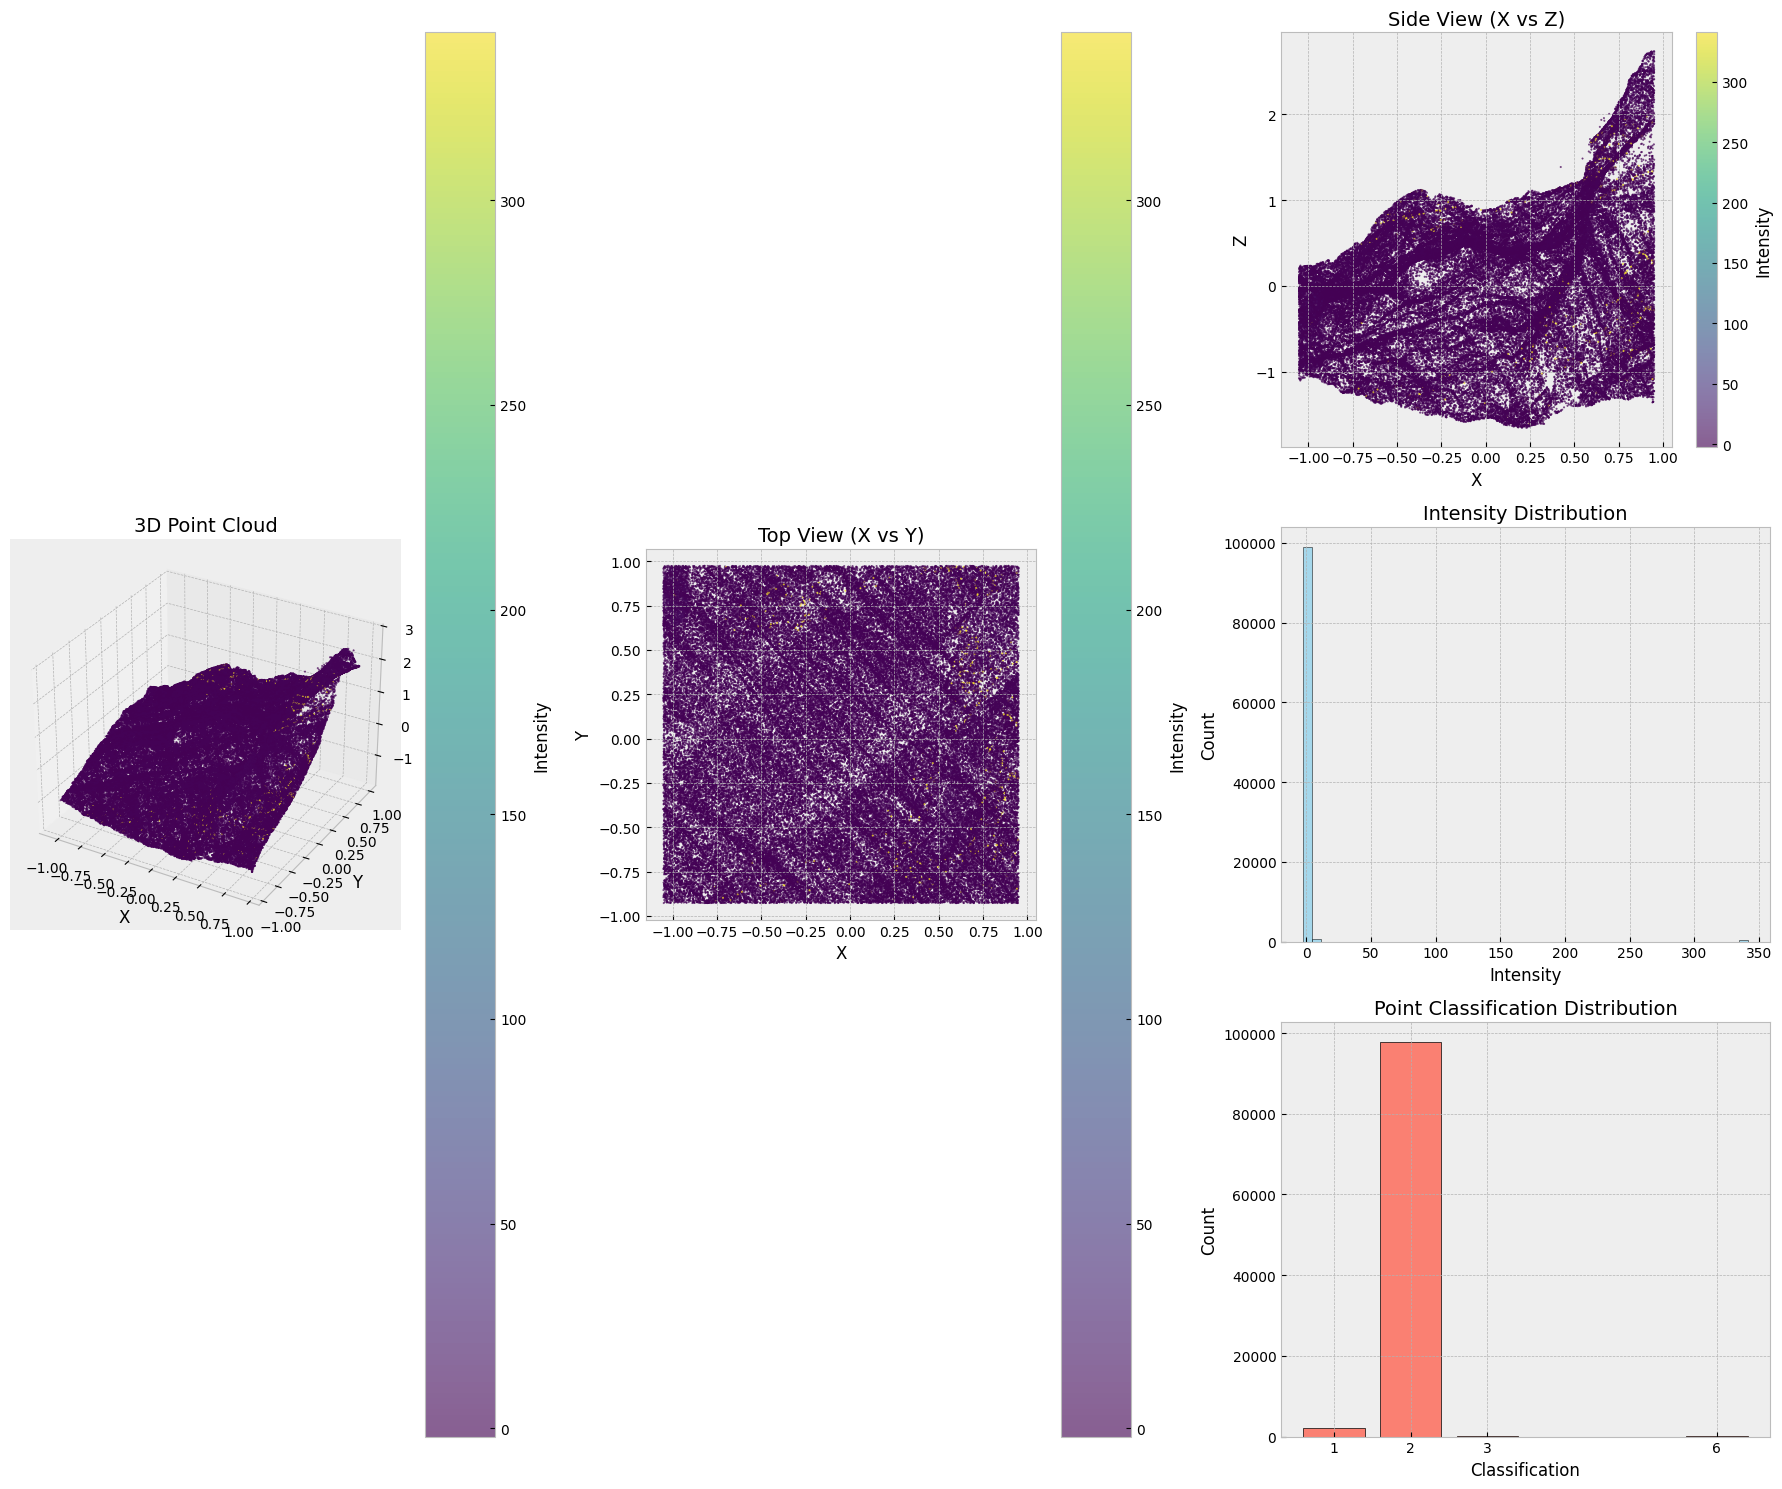

In [54]:
# Extract individual points and visualize
try:
    # Debug the structure of the dataframe
    print(f"DataFrame shape: {scaled_df.shape}")
    print(f"DataFrame columns: {scaled_df.columns.tolist()}")
    print("First row sample:")
    for col in scaled_df.columns:
        val = scaled_df[col].iloc[0]
        print(f"  {col}: {type(val).__name__}, ", end="")
        if isinstance(val, (list, np.ndarray)):
            print(f"length={len(val)}, sample={val[:3]}...")
        else:
            print(f"value={val}")
    
    # Process the dataframe
    point_df = extract_points_from_df(scaled_df, max_points=500_000)
    
    # Make sure visualize_li
    # dar can handle empty dataframes
    if len(point_df) > 0:
        fig = visualize_lidar(point_df, sample_size=min(100_000, len(point_df)))
        plt.show()
    else:
        print("No points to visualize!")
except Exception as e:
    print(f"Error during visualization: {str(e)}")
    import traceback
    traceback.print_exc()

## Create Additional Specialized Visualizations

Now let's create some more specialized visualizations focusing on specific aspects of the data:

In [ ]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def create_density_heatmap(scaled_df, resolution=100):
    """Create a 2D heatmap of point density"""
    # Ensure we have a clean dataframe with numerical X,Y values
    df_clean = scaled_df[['X', 'Y']].copy()
    
    # Drop any NaN values
    df_clean = df_clean.dropna()
    
    # Sample if dataset is large
    if len(df_clean) > 1_000_000:
        df_sample = df_clean.sample(1_000_000, random_state=42)
    else:
        df_sample = df_clean
        
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Create 2D histogram
    h = ax.hist2d(df_sample['X'], df_sample['Y'], 
                 bins=resolution, cmap='hot_r')
    
    ax.set_title('Point Density Heatmap', fontsize=15)
    ax.set_xlabel('X', fontsize=12)
    ax.set_ylabel('Y', fontsize=12)
    ax.set_aspect('equal')
    
    # Add colorbar (h[3] is the colorbar mappable object)
    cbar = fig.colorbar(h[3], ax=ax)
    cbar.set_label('Point Count')
    
    plt.tight_layout()
    return fig

def flatten_nested_points(df):
    """Extract points from dataframe that may contain nested arrays"""
    flat_data = {'X': [], 'Y': []}
    
    for _, row in df.iterrows():
        if isinstance(row['X'], (list, np.ndarray)):
            # Handle lists/arrays
            for j in range(len(row['X'])):
                x_val = row['X'][j]
                y_val = row['Y'][j]
                # Handle nested arrays (getting first element if array)
                x = x_val[0] if isinstance(x_val, (list, np.ndarray)) else x_val
                y = y_val[0] if isinstance(y_val, (list, np.ndarray)) else y_val
                
                if isinstance(x, (int, float)) and isinstance(y, (int, float)):
                    flat_data['X'].append(x)
                    flat_data['Y'].append(y)
        else:
            # Handle non-nested values
            if isinstance(row['X'], (int, float)) and isinstance(row['Y'], (int, float)):
                flat_data['X'].append(row['X'])
                flat_data['Y'].append(row['Y'])
    
    return pd.DataFrame(flat_data)

# Usage example (assuming point_df exists)
def create_and_display_heatmap(point_df):
    # Check if we need to flatten the dataframe
    needs_flattening = False
    sample_size = min(10, len(point_df))
    
    for i in range(sample_size):
        if isinstance(point_df['X'].iloc[i], (list, np.ndarray)):
            needs_flattening = True
            break
    
    if needs_flattening:
        print("Detected nested arrays, flattening data...")
        flat_df = flatten_nested_points(point_df)
        print(f"Created flat dataframe with {len(flat_df):,} points")
        density_fig = create_density_heatmap(flat_df)
    else:
        density_fig = create_density_heatmap(point_df)
    
    plt.show()
    return density_fig

Using existing point_df for density heatmap...


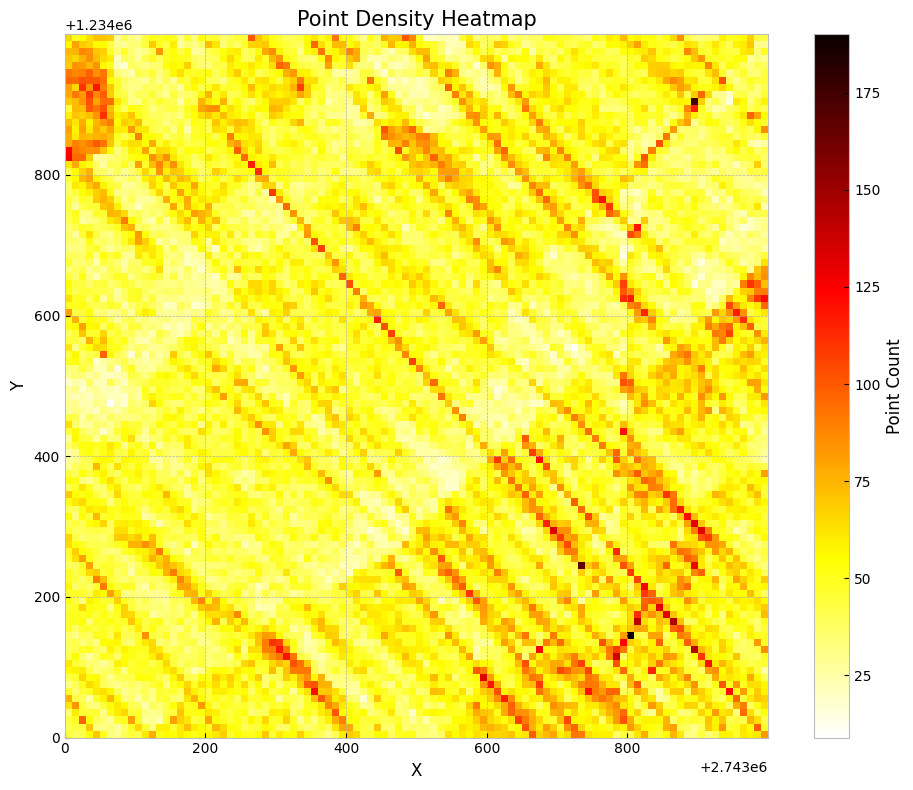

<Figure size 640x480 with 0 Axes>

In [41]:

# Use the density heatmap functions defined above

# Check if the point_df exists and is already processed
if 'point_df' in globals():
    print("Using existing point_df for density heatmap...")
    # Check if we need to further flatten data
    density_fig = create_and_display_heatmap(point_df)
else:
    print("Creating point dataframe for density heatmap...")
    # Create point dataframe from the list-based dataframe
    point_df = extract_points_from_df(df, max_points=500_000)
    density_fig = create_and_display_heatmap(point_df)

# Display the figure
plt.tight_layout()
plt.show()


Creating elevation profile with 500,000 points


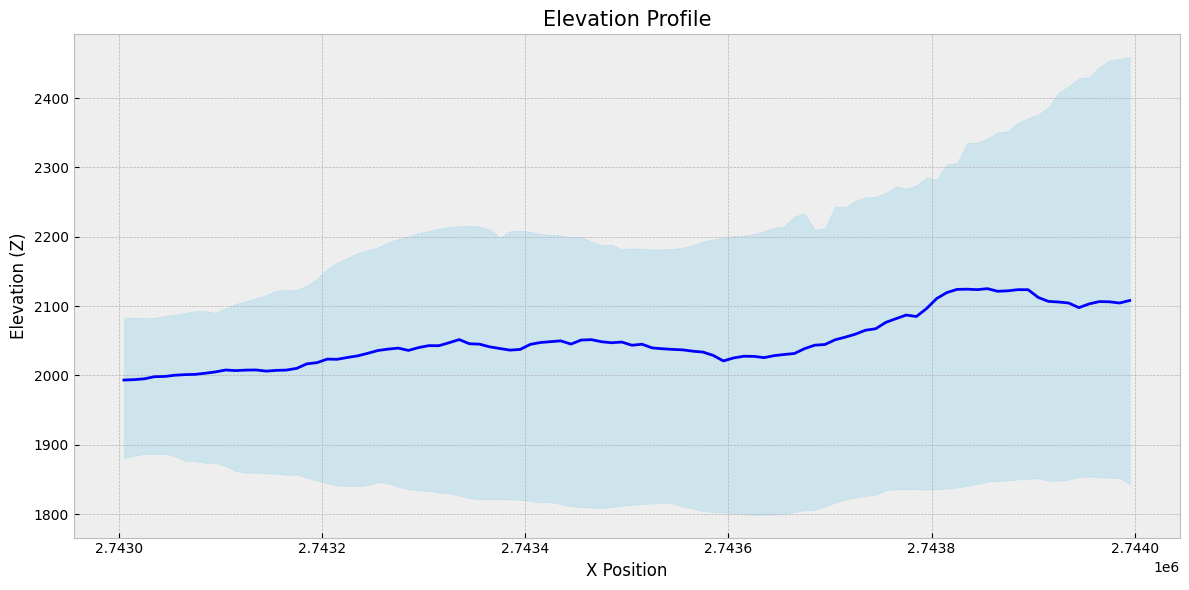

In [ ]:
# 2. Create elevation profile (if Z represents elevation)
def create_elevation_profile(scaled_df, num_bins=100, sample_size=500_000):
    """Create an elevation profile along the X axis"""
    # Check if we have point-based dataframe or nested lists
    if isinstance(scaled_df['X'].iloc[0], (list, np.ndarray)):
        print("Input dataframe has nested arrays. Using the flattened point_df instead.")
        # Use the previously created point_df if it exists
        if 'point_df' in globals():
            df_to_use = point_df
        else:
            # Handle the case when we need to flatten the data
            flat_data = {'X': [], 'Z': []}
            for i, row in scaled_df.iterrows():
                if isinstance(row['X'], (list, np.ndarray)) and isinstance(row['Z'], (list, np.ndarray)):
                    for j in range(len(row['X'])):
                        if isinstance(row['X'][j], (list, np.ndarray)):
                            flat_data['X'].append(row['X'][j][0])  # Take first element if nested
                            flat_data['Z'].append(row['Z'][j][0])
                        else:
                            flat_data['X'].append(row['X'][j])
                            flat_data['Z'].append(row['Z'][j])
                else:
                    flat_data['X'].append(row['X'])
                    flat_data['Z'].append(row['Z'])
            df_to_use = pd.DataFrame(flat_data)
    else:
        df_to_use = df
        
    # Sample if needed
    if len(df_to_use) > sample_size:
        df_sample = df_to_use.sample(sample_size, random_state=42)
    else:
        df_sample = df_to_use
    
    # Make sure values are numeric
    df_sample = df_sample.copy()
    df_sample['X'] = pd.to_numeric(df_sample['X'], errors='coerce')
    df_sample['Z'] = pd.to_numeric(df_sample['Z'], errors='coerce')
    
    # Drop any rows with NaN values
    df_sample = df_sample.dropna()
    
    print(f"Creating elevation profile with {len(df_sample):,} points")
    
    # Group X values into bins and calculate statistics of Z within each bin
    x_min, x_max = df_sample['X'].min(), df_sample['X'].max()
    bin_edges = np.linspace(x_min, x_max, num_bins + 1)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    # Assign each point to a bin
    bins = np.digitize(df_sample['X'], bin_edges)
    
    # Calculate statistics for each bin
    min_z = np.zeros(num_bins)
    max_z = np.zeros(num_bins)
    mean_z = np.zeros(num_bins)
    
    for i in range(1, num_bins + 1):
        bin_points = df_sample[bins == i]
        if len(bin_points) > 0:
            min_z[i-1] = bin_points['Z'].min()
            max_z[i-1] = bin_points['Z'].max()
            mean_z[i-1] = bin_points['Z'].mean()
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Plot the elevation profile
    ax.fill_between(bin_centers, min_z, max_z, alpha=0.3, color='skyblue')
    ax.plot(bin_centers, mean_z, 'b-', linewidth=2)
    
    ax.set_title('Elevation Profile', fontsize=15)
    ax.set_xlabel('X Position', fontsize=12)
    ax.set_ylabel('Elevation (Z)', fontsize=12)
    ax.grid(True)
    
    plt.tight_layout()
    return fig

# Create and display the elevation profile
# Try using point_df which should be already flattened
if 'point_df' in globals():
    elevation_fig = create_elevation_profile(point_df)
else:
    elevation_fig = create_elevation_profile(scaled_df)
plt.show()

Visualizing point classifications...


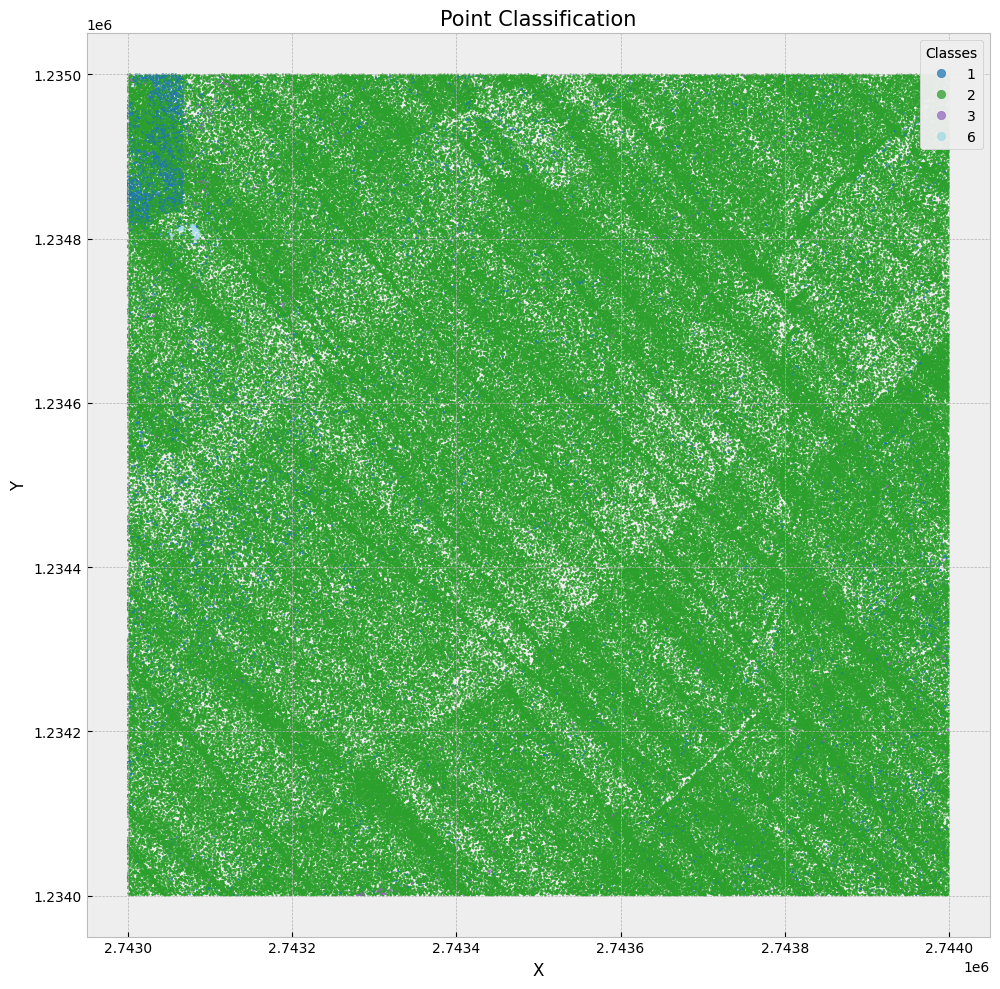

In [ ]:
# 3. Visualize the classification (if available)
if 'classification' in scaled_df.columns:
    print("Visualizing point classifications...")
    
    # Use point_df which has properly structured data
    if 'point_df' in globals() and 'classification' in point_df.columns:
        df_to_use = point_df
    else:
        print("Using extract_points_from_df to prepare data for visualization")
        df_to_use = extract_points_from_df(scaled_df, max_points=500_000)
    
    # Sample for visualization if needed
    if len(df_to_use) > 500_000:
        df_viz = df_to_use.sample(500_000, random_state=42)
    else:
        df_viz = df_to_use
    
    # Check if X and Y are lists or arrays and flatten them if needed
    if isinstance(df_viz['X'].iloc[0], (list, np.ndarray)):
        print("Flattening nested X, Y values for visualization")
        x_values = []
        y_values = []
        class_values = []
        
        for i, row in df_viz.iterrows():
            if isinstance(row['X'], (list, np.ndarray)):
                if isinstance(row['X'][0], (list, np.ndarray)):  # Double nested
                    x_values.extend([x[0] for x in row['X']])
                    y_values.extend([y[0] for y in row['Y']])
                else:  # Single nested
                    x_values.extend(row['X'])
                    y_values.extend(row['Y'])
                
                # Handle classification - could be scalar or list
                if isinstance(row['classification'], (list, np.ndarray)):
                    if len(row['classification']) == len(row['X']):
                        class_values.extend(row['classification'])
                    else:
                        class_values.extend([row['classification']] * len(row['X']))
                else:
                    class_values.extend([row['classification']] * len(row['X']))
            else:
                x_values.append(row['X'])
                y_values.append(row['Y'])
                class_values.append(row['classification'])
        
        # Create a temporary dataframe for plotting
        plot_df = pd.DataFrame({
            'X': x_values,
            'Y': y_values,
            'classification': class_values
        })
    else:
        plot_df = df_viz
    
    # Now plot the data
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # Get unique classifications and assign colors
    unique_classes = np.unique(plot_df['classification'])
    
    # Use scatter plot with different colors for each class
    scatter = ax.scatter(plot_df['X'], plot_df['Y'], 
                       c=plot_df['classification'], cmap='tab20', s=1, alpha=0.7)
    
    ax.set_title('Point Classification', fontsize=15)
    ax.set_xlabel('X', fontsize=12)
    ax.set_ylabel('Y', fontsize=12)
    ax.set_aspect('equal')
    
    # Add legend (only if there are not too many classes)
    if len(unique_classes) <= 20:
        legend1 = ax.legend(*scatter.legend_elements(),
                          loc="upper right", title="Classes")
        ax.add_artist(legend1)
    
    plt.tight_layout()
    plt.show()

## Export Processed Data (Optional)

If you want to save the processed data to a CSV or similar format for use in other applications:

In [ ]:
# You can save the DataFrame to CSV (useful for smaller datasets)
# df.to_csv('../data/processed_lidar_points.csv', index=False)

# For large datasets, consider using a more efficient format like parquet
# df.to_parquet('../data/processed_lidar_points.parquet')